In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import keras
import keras.preprocessing.image
from keras_retinanet.models.resnet import custom_objects
from keras_retinanet.preprocessing.csv_generator import CSVGenerator

import matplotlib.pyplot as plt
import cv2
import os
import numpy as np
import time

import tensorflow as tf

def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    return tf.Session(config=config)

# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
keras.backend.tensorflow_backend.set_session(get_session())

Using TensorFlow backend.


In [37]:
model = keras.models.load_model('../snapshots/resnet50_csv_06-10kbatch.h5', custom_objects=custom_objects)
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
padding_conv1 (ZeroPadding2D)   (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9408        padding_conv1[0][0]              
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu

c:\programdata\anaconda3\lib\site-packages\keras-2.1.2-py3.6.egg\keras\models.py:252: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [119]:
def add_noise(inData):
    result = np.random.normal(inData, scale=0.5).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result

def set_to_zero(inData):
    result = np.zeros(inData.shape).astype(np.uint8)
    print("adding noise ---- from {}:{} to {}:{}".format(inData.min(), inData.max(), result.min(), result.max()))
    return result

# create image data generator object
val_image_data_generator = keras.preprocessing.image.ImageDataGenerator()

In [100]:


# create a generator for testing data
validation_generator = CSVGenerator(
                'C:\\Users\\Kai\\study\\robot_prototype\\data\\MLRotation\\annotation2.txt',
                'C:\\Users\\Kai\\study\\robot_prototype\\data\\MLRotation\\classname2.txt',
                val_image_data_generator,
                batch_size=10
            )

In [120]:
# load image
index = np.random.randint(0,16800)
image = validation_generator.load_image(index)
print(image.shape)

(598, 830, 3)


In [121]:
# use this block to test against actual image
# image = cv2.imread("testImg/cellBaseRotated3.bmp.png")
# print(image.shape)

In [122]:
image = add_noise(image)

adding noise ---- from 1:255 to 0:255


In [123]:

# copy to draw on
draw = image.copy()
draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

# preprocess image for network
image = validation_generator.preprocess_image(image)
print(image.shape)
image, scale = validation_generator.resize_image(image)
print(image.shape)
annotations = validation_generator.load_annotations(index)

print(index)
print(validation_generator.image_path(index))
print(scale)
print(annotations)


(598, 830, 3)
(600, 833, 3)
10034
C:\Users\Kai\study\robot_prototype\data\MLRotation\resultImg/out_0_160_-20.png
1.0033444816053512
[[ 436.  176.  536.  276.    2.]]


In [124]:
# process image
start = time.time()
detections = None
_, _, detections = model.predict_on_batch(np.expand_dims(image, axis=0))
print("processing time: ", time.time() - start)

# compute predicted labels and scores
predicted_labels = np.argmax(detections[0, :, 4:], axis=1)
print(predicted_labels)
scores = detections[0, np.arange(detections.shape[1]), 4 + predicted_labels]
# correct for image scale
detections[0, :, :4] /= scale

processing time:  0.3054828643798828
[ 2  0  0  0  0  0  0  0  0 11  2 11 11  2 10 10  2 11  5  2 11  5 10  2 10
 11 10 11  7  2  2 11 11 11  0 11 11 11 11  2  5 11  7  2 11  1 11 10  5  0
 11 10  5 11 11 11 11 11 11 11  8 10 10  0 10 10 11 11 11 11 11 11 11 11 11
 11 11 11 11 11  1 11 11 11 11 11 11 11 11  2 11 11 11 11 11  1 11 11 11 11
 10 11 11 11 11 11 11 11 11 11  2 11 11 11 11 11 11  2 11 11 11 11 11 11 11
  0 11 10 10 11 11 11 11 11 11  5 11  9 11 10 11  5 11  4 11 11 11  3 11 11
 11 11 10 10 11 10 10 10 11 11 11 10 11 11 10 11 11 11 11  2 11 10 11 11 11
 11 11 11 10 11 11 11 10 11 11 11 10 10 10 11 11 10 11 11 11 11 11 11 11 11
 11 11 11 10 11 11 11 11 10 11 11 11 10 11 11  1 11 11  4 11 11 11 10 11  1
 11 11 11 11 10 11 11 11 11 11  3 10 11 11 11 11 11  5 11 11 10 11 11 11 10
 10 10 11 11 11 10 11 10 11 11 11 11 11 11 11  9 11 11 10 10 11 11 11  1 11
 10 11 10  1 10 11 11 10 11 11 10 11 11 11 11 11 11 11 11 10 11 11 11 11 10]


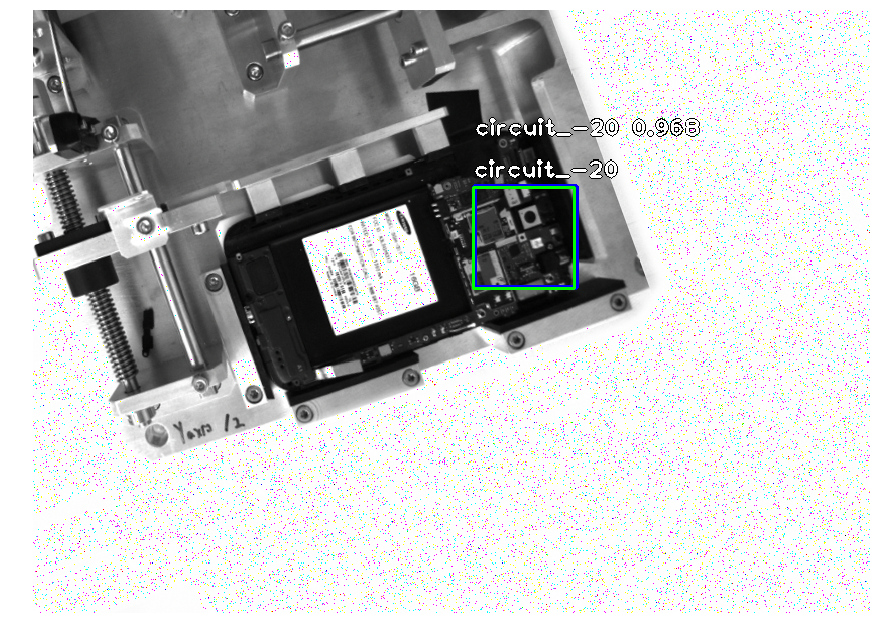

In [125]:
# visualize detections
for idx, (label, score) in enumerate(zip(predicted_labels, scores)):
    if score < 0.2:
        continue
    b = detections[0, idx, :4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 0, 255), 3)
    caption = "{} {:.3f}".format(validation_generator.label_to_name(label), score)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 50), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
# visualize annotations
for annotation in annotations:
    label = int(annotation[4])
    b = annotation[:4].astype(int)
    cv2.rectangle(draw, (b[0], b[1]), (b[2], b[3]), (0, 255, 0), 2)
    caption = "{}".format(validation_generator.label_to_name(label))
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (0, 0, 0), 3)
    cv2.putText(draw, caption, (b[0], b[1] - 10), cv2.FONT_HERSHEY_PLAIN, 1.5, (255, 255, 255), 2)
    
plt.figure(figsize=(15, 15))
plt.axis('off')
plt.imshow(draw)
plt.show()

In [8]:
print(detections[0:3])

[[[  2.85744751e+02   2.65987885e+02   3.85791565e+02 ...,   1.48602081e-02
     4.98664085e-14   3.32830094e-21]
  [  8.07744080e+02  -4.93854218e+01   8.67689575e+02 ...,   0.00000000e+00
     3.74702798e-26   3.39384701e-11]
  [  7.69423157e+02  -2.99134216e+01   9.07241760e+02 ...,   0.00000000e+00
     5.54013521e-19   8.60350593e-12]
  ..., 
  [ -1.73654251e+01   3.51410309e+02   2.54245796e+01 ...,   3.21989505e-13
     2.09937623e-11   9.10694276e-09]
  [ -1.75518341e+01   1.59993668e+02   2.51278286e+01 ...,   4.76512479e-14
     4.48823140e-12   9.05601638e-09]
  [  2.88710907e+02   3.27686646e+02   3.25267731e+02 ...,   2.42495135e-10
     4.83083396e-09   9.05038799e-09]]]


In [126]:
print(scores[0:3])

[ 0.96847767  0.12860303  0.11800113]
